## Import libraries

In [1]:
import numpy as np
import gym
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline

## Create the custom Frozen-lake (4*4) class

In [2]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete
from gym.envs.registration import register

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SSSS",
        "SHSH",
        "SSSH",
        "HSSG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


if 'FrozenLake_custom-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['FrozenLake_custom-v0']
            
register(
    id='FrozenLake_custom-v0',
    entry_point=FrozenLakeEnv,
    max_episode_steps=1000000
)

if 'FrozenLake_test-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['FrozenLake_test-v0']

register(
    id='FrozenLake_test-v0',
    entry_point=FrozenLakeEnv,
    max_episode_steps=100
)

## Training settings

In [3]:
def compute_mean_action_sr(M, obs_id, n_action=4):
    out_vec = np.zeros(16)
    for i in range(n_action):
        out_vec = out_vec + M[obs_id*n_action+i, :]
    out_vec = out_vec / float(n_action)
    return out_vec

In [4]:
env = gym.make('FrozenLake_custom-v0')

In [5]:
lr = 0.1
gamma = 0.9
M = np.zeros((16*4, 16))

## Training the successor representation

Total steps: 396252


<Figure size 432x288 with 0 Axes>

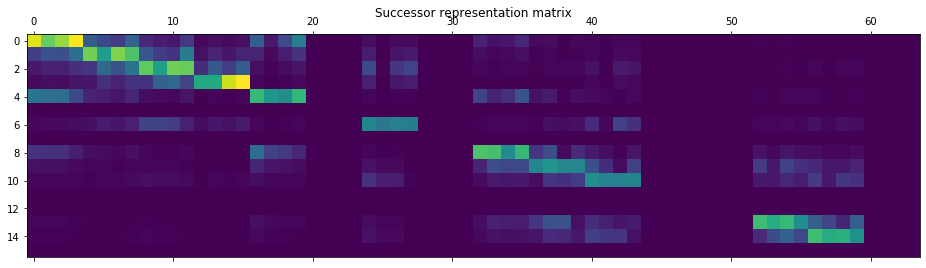

In [6]:
t_steps = 0
for i in range(100000):
    done = False
    obs = env.reset()
    j = 0
    while done != True:
        action = env.action_space.sample()
        if j == 0:
            current_act_idx = obs*4 + action
            current_obs_idx = obs
        else:
            next_act_idx = obs*4 + action
            next_obs_idx = obs
            next_sr_vec = compute_mean_action_sr(M, next_obs_idx)
            td_err = np.eye(16)[current_obs_idx] + gamma*next_sr_vec - M[current_act_idx, :]
            M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
            current_act_idx = next_act_idx
            current_obs_idx = next_obs_idx
        obs, rwd, done, _ = env.step(action)
        if done:
            next_obs_idx = obs
            next_sr_vec = compute_mean_action_sr(M, next_obs_idx)
            td_err = np.eye(16)[current_obs_idx] + gamma*next_sr_vec - M[current_act_idx, :]
            M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
            t_steps = t_steps + j
            break
        j = j + 1
    j = 0
print("Total steps:", t_steps)
plt.figure()
plt.matshow(M.T)
plt.title("Successor representation matrix")
plt.show()

## Computing Q_values

In [7]:
'''
Creating a matrix \overline{M}(s, a', s')
'''
def create_q_func_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            for k in range(n_action):
                tmp_M[i*n_action+j, i] = 0.0
    return tmp_M

In [8]:
def compute_intrisic_rewards(q_M, n_state=16, n_action=4):
    out_vec = np.zeros(n_state)
    for i in range(n_state):
        tmp_v = 0.0
        for j in range(n_action):
            tmp_v = tmp_v + np.sum(q_M[n_action*i + j])
        out_vec[i] = tmp_v
    return out_vec

In [9]:
def create_q_values(M, n_state=16, n_action=4):
    q_M = create_q_func_mat(M, n_state=n_state, n_action=n_action)
    int_rwds = compute_intrisic_rewards(q_M, n_state=n_state, n_action=n_action)
    q_vals = []
    for i in range(n_state*n_action):
        q_vals.append(np.dot(q_M[i,:], int_rwds))
    q_vals = np.array(q_vals).reshape(n_state, n_action)
    return q_vals

<Figure size 432x288 with 0 Axes>

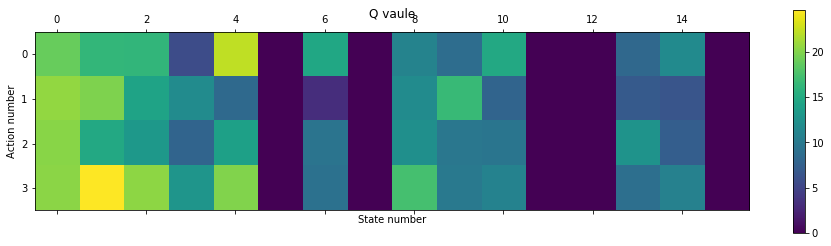

In [10]:
q_vals = create_q_values(M)

plt.figure()
plt.matshow(q_vals.T)
plt.colorbar()
plt.xlabel("State number")
plt.ylabel("Action number")
plt.title("Q vaule")
plt.show()

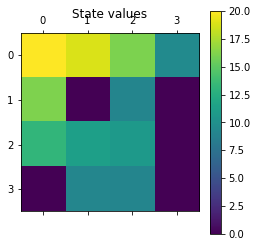

In [11]:
s_vals = np.mean(q_vals, axis=1).reshape(4, 4)
plt.matshow(s_vals)
plt.title("State values")
plt.colorbar()